# Imports

In [6]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import  scipy
import pickle

# Data

In [2]:
SAMPLE_SIZE = int(2e5)

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

## Create sample

In [105]:
data_frame = pd.read_csv('yelp_review_full_csv/data.csv', header=None, index_col=None)
data_frame.columns = ['Label', 'Text']
data_frame["Label"] -= 1

In [106]:
data_frame['Text_len'] = data_frame['Text'].str.split().map(lambda x: len(x))

<AxesSubplot: >

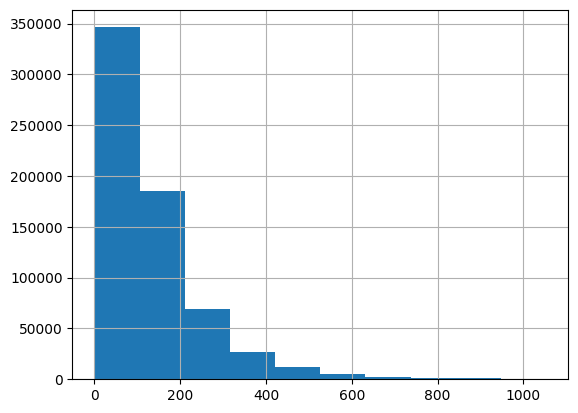

In [107]:
data_frame['Text_len'].hist()

In [108]:
max_text_len = np.percentile(data_frame['Text_len'], np.min([int(SAMPLE_SIZE / data_frame.shape[0] * 100 + 10), 100]))
max_text_len, np.sum(data_frame['Text_len'] < max_text_len)

(33.0, 83240)

In [109]:
data_frame = data_frame[data_frame['Text_len'] < max_text_len]

In [110]:
data_frame

,Label,Text,Text_len
15,4,Can't miss stop for the best Fish Sandwich in ...,10
18,4,Good fish sandwich.,3
28,1,Hoofah.,1
29,3,I heart King's. I've always been a fan and thi...,20
36,4,Love this place. Never had a bad meal. Good ...,19
...,...,...,...
649979,4,Best hidden secret in Vegas..... Great selecti...,15
649985,3,"We tried the Cheese Danish w lemon. Creamy, fl...",21
649989,4,"By far the best croissant, flakey, crisp, ever...",27
649992,4,"Great communication, They came out and found m...",22


In [111]:
a = []
for i in data_frame['Label'].unique():
    a.append(data_frame[data_frame['Label']==i][:(SAMPLE_SIZE // len(data_frame['Label'].unique()))])
data_frame = pd.concat(a)
data_frame = data_frame.sample(frac=1)
data_frame = data_frame.reset_index()
del data_frame['index']

In [112]:
with open(f'data{SAMPLE_SIZE}_df.pic', 'wb') as f: 
    pickle.dump(data_frame, f)

## check sample

In [8]:
with open(f'data{SAMPLE_SIZE}_df.pic', 'rb') as f:
    data_frame = pickle.load(f)

In [114]:
data_frame

,Label,Text,Text_len
0,0,Took 20min to get entr\u00e9e out. Took 10min ...,21
1,1,This property is in major need of an upgrade. ...,29
2,3,"Whenever I make a trip out to AZ, I always sto...",24
3,3,Great place...excellent fried catfish.,4
4,4,"Wow, great fresh food!\ntomato mozzarella sand...",25
...,...,...,...
19995,2,Food is great and our waiter was great but foo...,29
19996,2,Not your usual pizzas (the specialty ones). I ...,27
19997,0,Ugh! Walmart. I wish the staff here cared more.,9
19998,0,My one experience here involved squalid condit...,24


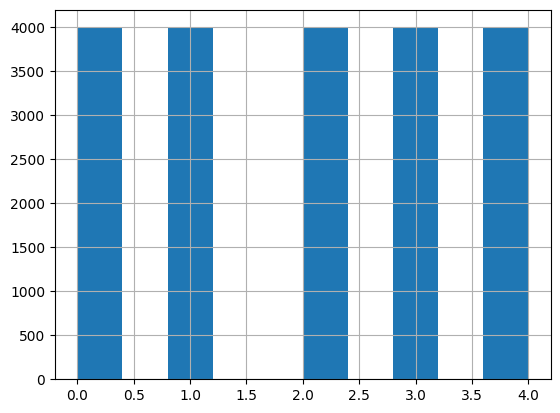

In [115]:
data_frame['Label'].hist();

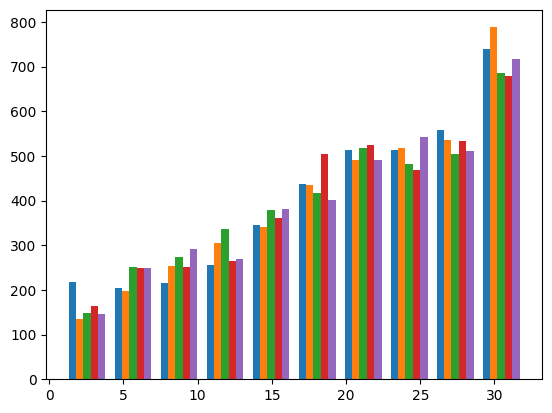

In [116]:
plt.hist([data_frame[data_frame['Label']==i]['Text_len'] for i in data_frame['Label'].unique()]);

# Backbone

In [29]:
TRANSFORMER_NAME = 'facebook/bart-base'
MODEL_NAME = 'facebook_bart_base'

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [30]:
backbone = transformers.TFAutoModel.from_pretrained(TRANSFORMER_NAME)

All PyTorch model weights were used when initializing TFBartModel.

All the weights of TFBartModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartModel for predictions without further training.


Load tokenizer to be used with the model

In [31]:
tokenizer = transformers.AutoTokenizer.from_pretrained(TRANSFORMER_NAME)

In [148]:
backbone.summary()

Model: "tf_funnel_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 funnel (TFFunnelMainLayer)  multiple                  130973184 
                                                                 
Total params: 130973184 (499.62 MB)
Trainable params: 130973184 (499.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [280]:
tokenize_seq = []

for text in tqdm.tqdm(data_frame['Text']):
    tokenize_seq.append(tokenizer(text)['input_ids'])

  0%|          | 0/20000 [00:00<?, ?it/s]

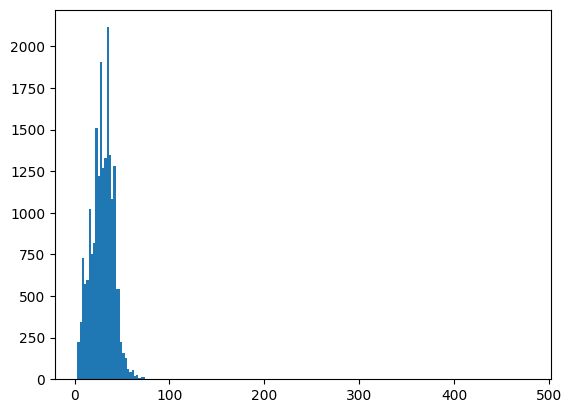

In [281]:
plt.hist([len(tok) for tok in tokenize_seq], 200);

In [282]:
num_token = int(np.percentile([len(tok) for tok in tokenize_seq], 99))
num_token

58

In [283]:
X = tf.keras.preprocessing.sequence.pad_sequences(
    tokenize_seq,
    maxlen=num_token,
    truncating='post',
    padding='post',
    value=tokenizer.pad_token_id)

In [284]:
text_dataset = tf.data.Dataset.from_tensor_slices(X).batch(64)

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

In [295]:
features = []
for data in tqdm.tqdm(text_dataset):
    features.extend(tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1))

  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [169]:
features = np.array(features)

In [171]:
features.shape

(20000, 768)

In [178]:
with open(f'fetures_data/{MODEL_NAME}_features_ar_data{SAMPLE_SIZE}.pic', 'wb') as f:
    pickle.dump(features, f)

In [179]:
features.shape

(20000, 768)

In [180]:
features[0].shape

(768,)

# Prepare train/test data

In [32]:
with open(f'fetures_data/{MODEL_NAME}_features_ar_data{SAMPLE_SIZE}.pic', 'rb') as f:
    features = pickle.load(f)

In [ ]:
# features = X

In [33]:
y = np.array(data_frame['Label'])

Split your data (extracted features and labels) into train and test subsets.

In [34]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [35]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(64)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(64)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [36]:
inputs = tf.keras.layers.Input(features.shape[1], name='input', dtype=tf.int32)
x = tf.keras.layers.Dense(512, name='Dense1', activation='relu')(inputs)
x = tf.keras.layers.Dense(len(data_frame['Label'].unique()), name='prediction')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='MyModel')

In [37]:
model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 Dense1 (Dense)              (None, 512)               393728    
                                                                 
 prediction (Dense)          (None, 5)                 2565      
                                                                 
Total params: 396293 (1.51 MB)
Trainable params: 396293 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model. Choose loss and metrics.

In [38]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics='accuracy')

# Train the model

In [39]:
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
235/235 [==============================] - 1s 5ms/step - loss: 1.6510 - accuracy: 0.1967 - val_loss: 1.6209 - val_accuracy: 0.1948
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 1.5823 - accuracy: 0.2610 - val_loss: 1.6310 - val_accuracy: 0.2036
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 1.5215 - accuracy: 0.3215 - val_loss: 1.6619 - val_accuracy: 0.1980
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 1.4342 - accuracy: 0.3901 - val_loss: 1.7262 - val_accuracy: 0.1998
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 1.3280 - accuracy: 0.4581 - val_loss: 1.8192 - val_accuracy: 0.2000
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 1.2067 - accuracy: 0.5255 - val_loss: 1.8786 - val_accuracy: 0.1958
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 1.0851 - accuracy: 0.5935 - val_loss: 1.9727 - val_accuracy: 0.1898
Epoch 

# Evaluation

Evalute the model on test data.

In [40]:
predict = model.predict(X_test).argmax(axis=-1)

157/157 [==============================] - 0s 955us/step


Plot confusion matrix.

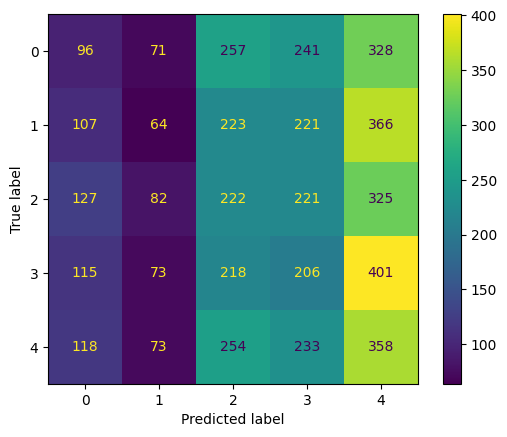

In [41]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, predict)

Write a function to classify a piece of text.

In [104]:
def classify_text(text: str) -> tuple[int | str, np.ndarray]:
    '''Classifes the given `text` using the trained model.

    Arguments:
        text: text to be classified

    Return:
        The assigned label and probabilites of all labels'''
    tokens = [tokenizer(text)['input_ids']]
    text_dataset = tf.data.Dataset.from_tensor_slices(tokens).batch(1)

    for data in text_dataset:
        features = tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1)
    predict = scipy.special.softmax(model.predict(features, verbose=0))
    return predict.argmax(axis=1), predict[0]

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [105]:
i = 4
text = data_frame.iloc[i]['Text']
# text = "tasty"
print(text)
pr = classify_text(text)


print(data_frame.iloc[i]['Label'], pr[1])

Trek here was grueling. Dinner did not satisfy my taste buds. Prices were high. \n\nME NO LIKEY.
1 [0.16975169 0.40039432 0.2660075  0.16170914 0.00213741]


# Bonus

Write a function that computes word impact on text label. 

In [107]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    '''Determines word impact on text label.

    Arguments:
        text: Sample text to be used for computation.

    Returns:
        A list of pairs: the word and vector of probability changes for each class'''
        
    full_text_pr = classify_text(text)[1]
    pr = {}
    spl_text = text.split()
    for i, word in enumerate(spl_text):
        txt = ' '.join(spl_text[:i] + spl_text[i+1:])
        pr[f'{word}'] = full_text_pr - classify_text(txt)[1]
    return pr

Try to find out words that make text have a specific label.

In [108]:
i = 4
text = data_frame.iloc[i]['Text']
# text = "tasty"
print(text)
pr = get_words_impact(text)

Trek here was grueling. Dinner did not satisfy my taste buds. Prices were high. \n\nME NO LIKEY.


In [110]:
pr

{'Trek': array([ 0.10853873,  0.24194221,  0.2548365 , -0.58987   , -0.01544743],
       dtype=float32),
 'here': array([ 0.07622301,  0.30331665, -0.17096633, -0.17835988, -0.03021334],
       dtype=float32),
 'was': array([-0.02730158,  0.26917785,  0.17797095, -0.4014058 , -0.01844131],
       dtype=float32),
 'grueling.': array([ 0.01209645,  0.4000675 ,  0.26533934, -0.67919093,  0.00168768],
       dtype=float32),
 'Dinner': array([ 0.16672353,  0.3983063 ,  0.06783766,  0.15090847, -0.78377587],
       dtype=float32),
 'did': array([ 0.03354743,  0.39986068,  0.26039124, -0.6531055 , -0.04069378],
       dtype=float32),
 'not': array([ 0.04189342,  0.29938102, -0.39310673,  0.05724932, -0.00541696],
       dtype=float32),
 'satisfy': array([ 0.04863428,  0.37610802,  0.17755273, -0.52932847, -0.07296643],
       dtype=float32),
 'my': array([ 0.16381603,  0.39679518, -0.7163192 ,  0.15861726, -0.00290919],
       dtype=float32),
 'taste': array([-0.11361884,  0.39571357, -0.0246

In [83]:
a = [1, 2, 3]
b = [2 , 3, 4]
a + b

[1, 2, 3, 2, 3, 4]